### Importing Important Libraries

In [2]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
!pip install statsmodels
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

Get weekly sentiment for stock ticker¶
There is much more to the process of stock price formation than plain historical data. Over 1 day, one online post might be a turning point in the course of events, which may result in the market crash. Elon Musk tweets, coronavirus, start of russian full-scale invasion of Ukraine are the proof to that. Therefore, we will take into account another important external indicator, such as the mood of stock market participants. The most effective method in this task is the analysis of the tone (sentiment analysis) of the text, in this notewook we will be consider posts in the social network Twitter.

In [4]:
!pip install contractions


In [5]:
"""
Text Preprocessing Function (NLP Cleaning Pipeline)

This function preprocesses raw text data to make it suitable for NLP tasks
such as sentiment analysis, classification, or topic modeling.

Steps performed:
1. Convert text to lowercase for uniformity.
2. Remove URLs (http, https, www) to eliminate irrelevant links.
3. Remove user mentions (@username) and hashtags (#topic), commonly found
   in social media text.
4. Remove remaining '@' and '#' symbols.
5. Convert text to ASCII, removing emojis and non-English characters.
6. Expand contractions (e.g., "can't" -> "cannot") using the contractions library.
7. Replace special symbols and HTML entities:
   - '%' -> 'percent'
   - '&amp' -> 'and'
   - '&gt' -> 'greater than'
8. Normalize common financial and technical abbreviations:
   - 'p&f' -> 'point and figure'
   - 's&p' -> 'SP500'
   - 'p/e' -> 'pe ratio'
   - 'b/c' -> 'because'
   - 'b/o' -> 'break out'
9. Replace stock ticker mentions (e.g., $AAPL) with the word 'stock'.

Purpose:
This cleaning pipeline reduces noise, standardizes language, and improves
model performance by converting informal, noisy text into a structured
and consistent format.
"""

import re
import contractions
# Define the preprocessing steps
def preprocess_text (text) :

  text = text.lower()

  text = re.sub(r'https?:\/V.*[\r\n]*',' ', text)
  text = re.sub(r'www.*[\r\n]*','', text)
  text = re.sub(r'https', ' ', text)
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

  text = re. sub(r'\@\w+','',text)
  text = re.sub(r'\#\w+', '', text)
  text = re.sub(r'@[a-z0-9]+', '', text)
  text = re.sub(r'#[a-z0-9]', '', text)
  text = re.sub(r'@', '', text)
  text = re.sub(r'#', '', text)
  text = text.encode('ascii', 'ignore').decode('ascii')
  text = contractions.fix(text)
  text = text. replace('%', ' percent')
  text = re. sub(r'&amp','and ', text)
  text = re.sub(r'&gt', ' greater than ', text)

  text = re. sub(r'p&f', 'point and figure', text)
  text = re. sub(r's&p', 'SP500', text)
  text = re. sub(r'q&a', 'question and answer', text)
  text = re.sub(r'b/c', ' because ', text)
  text = re.sub(r'b/o', ' break out ', text)
  text = re. sub(r'p/e','pe ratio', text)
  text = re.sub(r'\$[a-zA-Z]+', 'stock', text, flags=re.IGNORECASE)

  return text

In [6]:
all_tweets = pd.read_csv('stock_tweets.csv')

In [7]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [8]:
(all_tweets["Stock Name"].unique())


array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

In [9]:
stock_name = 'TSLA'
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
sent_df = df.copy()
df.head()

(37422, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [10]:
!pip install transformers torch


In [11]:
"""
BERT (Bidirectional Encoder Representations from Transformers)

BERT is a pre-trained deep learning model designed for understanding the
meaning and context of natural language text. Unlike traditional models
that read text from left to right or right to left, BERT reads text
bidirectionally, meaning it looks at both the left and right context of
each word at the same time.

Core Ideas:
1. Bidirectional Context:
   BERT understands a word based on all surrounding words, which allows
   it to capture context more accurately. For example, the word "bank"
   will be understood differently in "river bank" vs "bank account".

2. Transformer Architecture:
   BERT is built using transformers, which rely on self-attention
   mechanisms instead of recurrence. Self-attention allows the model
   to focus on the most relevant words in a sentence, regardless of
   their position.

3. Pre-training:
   BERT is trained on large text corpora using two tasks:
   - Masked Language Modeling (MLM): Random words are masked, and the
     model learns to predict them.
   - Next Sentence Prediction (NSP): The model learns whether one
     sentence logically follows another.

4. Fine-tuning:
   After pre-training, BERT can be fine-tuned for specific tasks such as
   sentiment analysis, text classification, question answering, or
   named entity recognition by adding a small task-specific layer.

In This Project:
- A pre-trained BERT sentiment model is used.
- Input text is tokenized into numerical tokens.
- BERT produces contextual embeddings.
- A classification head outputs sentiment scores.
- Softmax converts these scores into probabilities.

Why BERT is Powerful:
- Understands context, not just keywords
- Handles complex language patterns
- Works well with minimal task-specific training

Limitation:
- Computationally expensive
- Slower than traditional ML models
- Has a fixed maximum input length

Overall, BERT provides state-of-the-art performance for many NLP tasks
by deeply understanding the structure and meaning of language.
"""


'\nBERT (Bidirectional Encoder Representations from Transformers)\n\nBERT is a pre-trained deep learning model designed for understanding the\nmeaning and context of natural language text. Unlike traditional models\nthat read text from left to right or right to left, BERT reads text\nbidirectionally, meaning it looks at both the left and right context of\neach word at the same time.\n\nCore Ideas:\n1. Bidirectional Context:\n   BERT understands a word based on all surrounding words, which allows\n   it to capture context more accurately. For example, the word "bank"\n   will be understood differently in "river bank" vs "bank account".\n\n2. Transformer Architecture:\n   BERT is built using transformers, which rely on self-attention\n   mechanisms instead of recurrence. Self-attention allows the model\n   to focus on the most relevant words in a sentence, regardless of\n   their position.\n\n3. Pre-training:\n   BERT is trained on large text corpora using two tasks:\n   - Masked Languag

In [12]:
"""
BERT-Based Sentiment Model Initialization

This code loads a pre-trained BERT model and tokenizer for sentiment analysis
using the Hugging Face Transformers library.

Steps:
1. Import required libraries for data handling (pandas, numpy),
   deep learning (torch), and NLP (transformers).
2. Specify the pre-trained model:
   "nlptown/bert-base-multilingual-uncased-sentiment", which is trained to
   classify text sentiment into 1–5 star ratings across multiple languages.
3. Load the BERT tokenizer to convert raw text into token IDs understood
   by the model.
4. Load the BERT sequence classification model with pre-trained weights.
5. Detect available hardware:
   - Use GPU (CUDA) if available for faster inference
   - Otherwise, fall back to CPU
6. Move the model to the selected device and set it to evaluation mode
   to disable training-specific layers like dropout.

Purpose:
This setup prepares a ready-to-use deep learning model for performing
sentiment inference on text data efficiently and consistently.
"""

import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.special import softmax
MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
"""
BERT-Based Sentiment Analysis Pipeline

This code performs sentiment analysis on text data using a pre-trained
BERT model and assigns a continuous sentiment score to each text entry.

Model Details:
- Uses the pre-trained model:
  "nlptown/bert-base-multilingual-uncased-sentiment"
- The model outputs probabilities for 5 sentiment classes
  (very negative → very positive).
- The model runs on GPU if available, otherwise on CPU, and is set to
  evaluation mode to disable training-specific behavior.

Sentiment Scoring Logic:
1. Input text is first cleaned using a preprocessing function to remove
   noise such as URLs, mentions, and symbols.
2. The cleaned text is tokenized into input IDs and attention masks
   using the BERT tokenizer.
3. The BERT model produces raw output logits for sentiment classes.
4. Softmax is applied to convert logits into class probabilities.
5. A weighted average of class probabilities is computed to obtain a
   continuous sentiment score in the range [0, 1].
6. The score is rescaled to the range [-1, 1], where:
   - -1 indicates strongly negative sentiment
   -  0 indicates neutral sentiment
   - +1 indicates strongly positive sentiment

DataFrame-Level Processing:
- The sentiment score is computed for each text entry in the 'Tweet'
  column.
- The resulting scores are stored in a new column called
  'Sentiment_Score'.

Purpose:
This pipeline converts unstructured text into a numerical sentiment
signal that can be used for analysis, visualization, or integration
with trading, forecasting, or decision-making systems.
"""

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.special import softmax

MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Function to preprocess text and get sentiment score using BERT
def get_bert_sentiment(text):
    tweet = preprocess_text(text)

    inputs = tokenizer(
        tweet,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=64
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = softmax(logits.cpu().numpy()[0])

    # Weighted sentiment score (0 to 1)
    sentiment_score = sum(
        i * prob for i, prob in enumerate(probabilities)
    ) / (len(probabilities) - 1)

    # Scale to [-1, 1]
    scaled_score = 2 * (sentiment_score - 0.5)
    return scaled_score


# Apply sentiment analysis to DataFrame
def analyze_sentiment_with_bert(df):
    df['Sentiment_Score'] = df['Tweet'].apply(get_bert_sentiment)
    return df


# Run sentiment analysis
sent_df = analyze_sentiment_with_bert(sent_df)

print(sent_df[['Tweet', 'Sentiment_Score']])


In [ ]:
sent_df.head()
sent_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 37422 entries, 0 to 37421
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Date             37422 non-null  datetime64[ns, UTC]
 1   Tweet            37422 non-null  object             
 2   Stock Name       37422 non-null  object             
 3   Company Name     37422 non-null  object             
 4   Sentiment_Score  37422 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 1.7+ MB


In [ ]:
# sent_df['Sentiment_Score'] = pd.to_numeric(sent_df['Sentiment_Score'], errors='coerce')
sent_df['Date'] = pd.to_datetime(sent_df['Date'], errors='coerce')

# Verify the conversion
print(sent_df['Date'].dtype)


datetime64[ns, UTC]


In [ ]:
daily_sentiment = sent_df.groupby(sent_df['Date'].dt.date).agg({

    'Sentiment_Score': 'mean'
}).reset_index()
daily_sentiment.head()


,Date,Sentiment_Score
0,2021-09-30,-0.124677
1,2021-10-01,-0.057836
2,2021-10-02,0.075078
3,2021-10-03,0.041074
4,2021-10-04,-0.113931


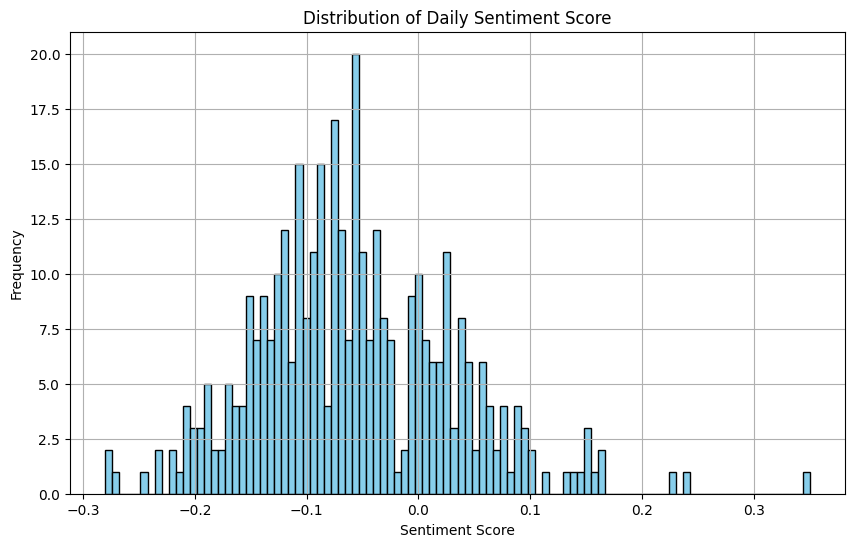

In [ ]:
# Plotting the distribution of 'Sentiment_Score'
plt.figure(figsize=(10, 6))
plt.hist(daily_sentiment['Sentiment_Score'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Daily Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'], errors='coerce')


print(daily_sentiment['Date'].dtype)

datetime64[ns]


In [ ]:
all_stocks = pd.read_csv('stock_tweets.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [ ]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])


/tmp/ipykernel_35/2969278197.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
stock_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        252 non-null    datetime64[ns]
 1   Open        252 non-null    float64       
 2   High        252 non-null    float64       
 3   Low         252 non-null    float64       
 4   Close       252 non-null    float64       
 5   Adj Close   252 non-null    float64       
 6   Volume      252 non-null    int64         
 7   Stock Name  252 non-null    object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 17.7+ KB


In [ ]:
final_df = pd.merge(stock_df, daily_sentiment, left_on='Date', right_on='Date', how='inner')
final_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Sentiment_Score
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,-0.124677
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,-0.057836
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,-0.113931
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,-0.106666
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,-0.023411


In [ ]:
final_df.to_csv('Stoc_sentiment_output.csv', index=False)
 

loaded_df = pd.read_csv('Stoc_sentiment_output.csv')
data = loaded_df.copy()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Sentiment_Score
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,-0.124677
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,-0.057836
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,-0.113931
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,-0.106666
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,-0.023411


In [ ]:
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             252 non-null    datetime64[ns]
 1   Open             252 non-null    float64       
 2   High             252 non-null    float64       
 3   Low              252 non-null    float64       
 4   Close            252 non-null    float64       
 5   Adj Close        252 non-null    float64       
 6   Volume           252 non-null    int64         
 7   Stock Name       252 non-null    object        
 8   Sentiment_Score  252 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 17.8+ KB


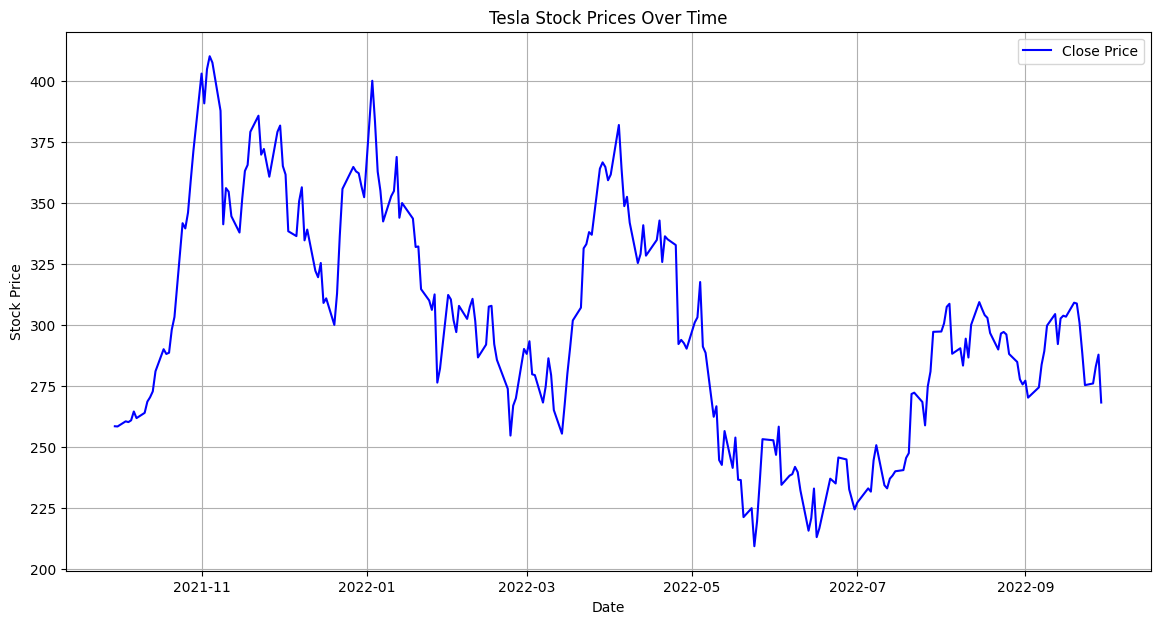

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label="Close Price", color='blue')
plt.title("Tesla Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()

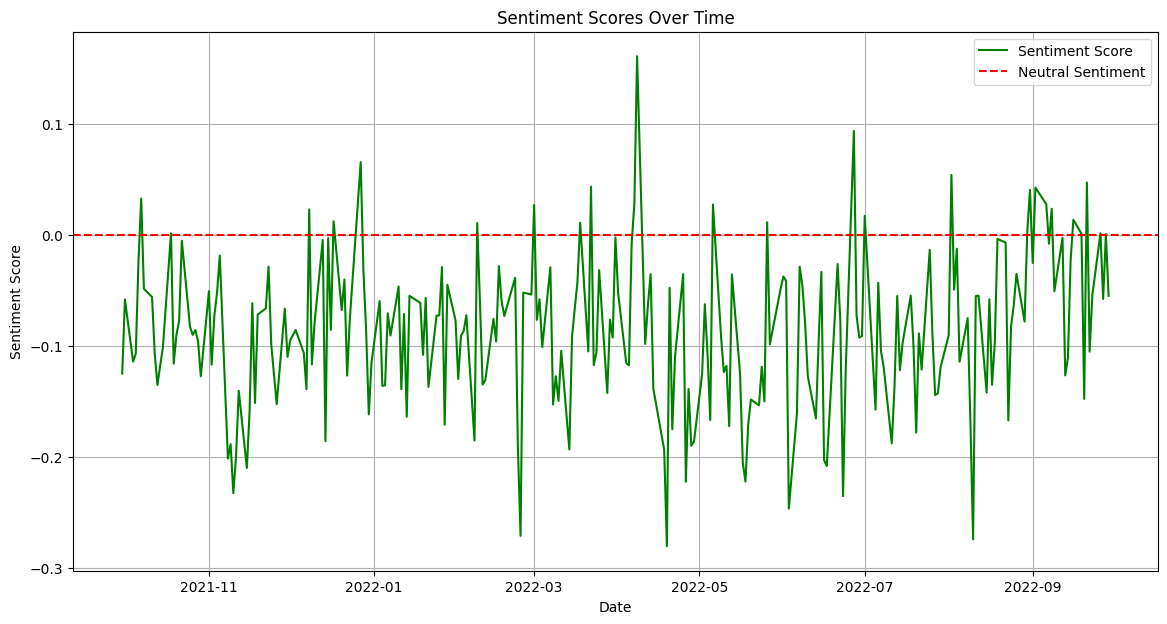

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



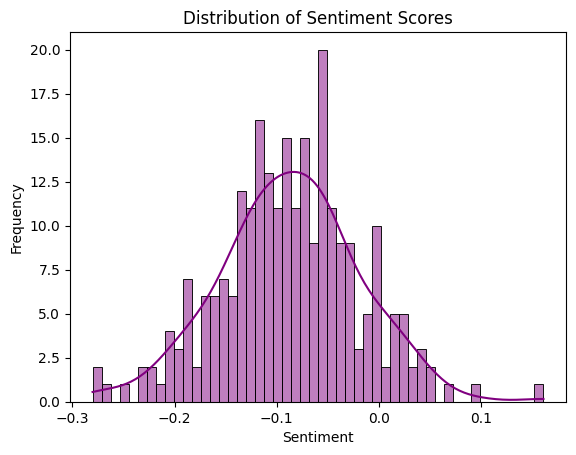

In [ ]:
import seaborn as sns
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Sentiment_Score'], label="Sentiment Score", color='green')
plt.axhline(y=0, color='red', linestyle='--', label="Neutral Sentiment")
plt.title("Sentiment Scores Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid()
plt.show()

# Distribution of sentiment scores
sns.histplot(df['Sentiment_Score'], bins=50, kde=True, color='purple')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()


In [ ]:
df.describe


<bound method NDFrame.describe of           Date        Open        High         Low       Close   Adj Close  \
0   2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1   2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2   2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3   2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4   2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
..         ...         ...         ...         ...         ...         ...   
247 2022-09-23  283.089996  284.500000  272.820007  275.329987  275.329987   
248 2022-09-26  271.829987  284.089996  270.309998  276.010010  276.010010   
249 2022-09-27  283.839996  288.670013  277.510010  282.940002  282.940002   
250 2022-09-28  283.079987  289.000000  277.570007  287.809998  287.809998   
251 2022-09-29  282.760010  283.649994  265.779999  268.209991  268.209991   

       Volume Stock Name  Sen

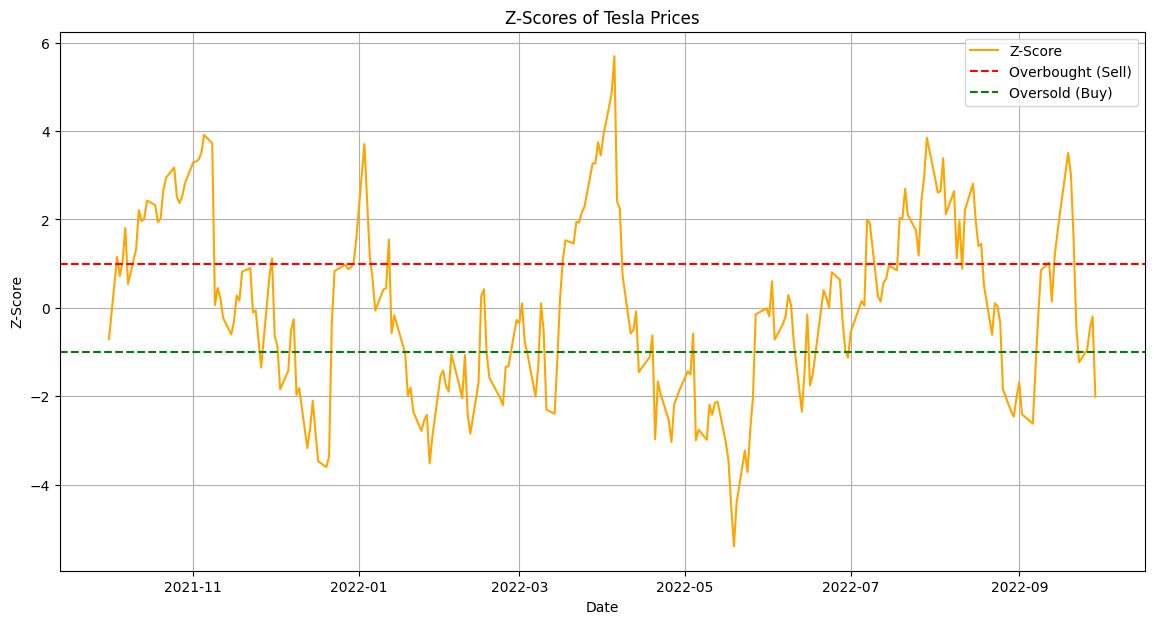

In [ ]:
df1=df.copy()
# Calculate moving averages
df1['ma_20'] = df1['Close'].rolling(window=20,min_periods=1).mean()
df1['z_score'] = (df1['Close'] - df1['ma_20']) / df1['Close'].rolling(window=7, min_periods=1).std()
# Plot z-scores
plt.figure(figsize=(14, 7))
plt.plot(df1['Date'], df1['z_score'], label="Z-Score", color='orange')
plt.axhline(y=1, color='red', linestyle='--', label="Overbought (Sell)")
plt.axhline(y=-1, color='green', linestyle='--', label="Oversold (Buy)")
plt.title("Z-Scores of Tesla Prices")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid()
plt.show()

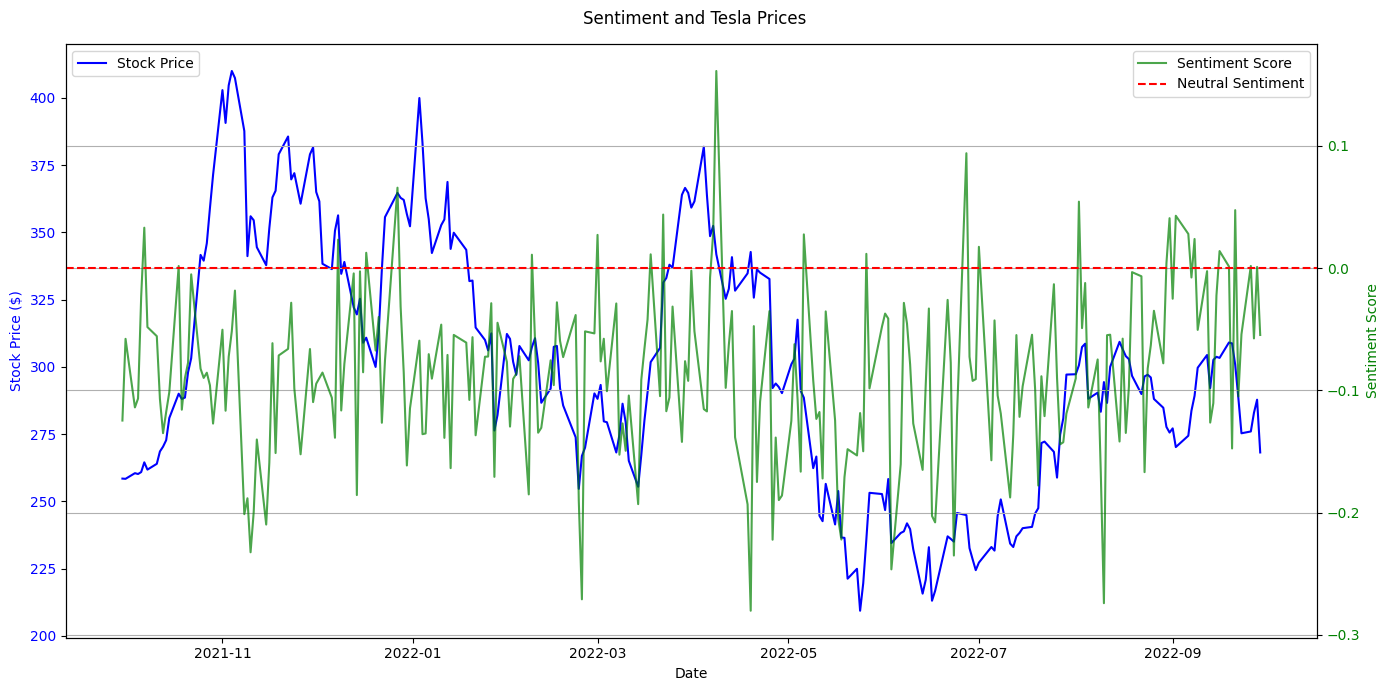

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 7))


ax1.plot(df1['Date'], df1['Close'], label="Stock Price", color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price ($)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.plot(df1['Date'], df1['Sentiment_Score'], label="Sentiment Score", color='green', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', label="Neutral Sentiment")
ax2.set_ylabel("Sentiment Score", color='green')
ax2.tick_params(axis='y', labelcolor='green')


fig.suptitle("Sentiment and Tesla Prices")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.grid()
plt.show()

In [ ]:
"""
Feature Engineering and Correlation Analysis

This code block explores the relationship between sentiment-based features
and future price returns over multiple time horizons.

Steps:
1. Future Returns Calculation:
   - Future returns are computed for multiple lags (1, 3, 7, 14 days)
     using forward-shifted closing prices.
   - Formula:
     future_return_lag_n = (Close[t + n] / Close[t]) - 1

2. Sentiment Feature Engineering:
   - sentiment_volatility:
     Rolling standard deviation of sentiment scores over a 3-period window,
     capturing short-term sentiment instability.
   - lagged_sentiment:
     Previous-period sentiment score, used to study delayed sentiment impact.

3. Correlation Computation:
   - A correlation matrix is calculated between sentiment features and
     future returns at different lags.
   - This helps identify whether sentiment has predictive power over
     short-, medium-, or longer-term returns.

4. Visualization:
   - A heatmap is created using Plotly to visually inspect the strength
     and direction of correlations.
   - Positive values indicate positive relationships, negative values
     indicate inverse relationships.

Purpose:
This analysis evaluates whether sentiment signals and their dynamics
(volatility and lag effects) are statistically related to future price
movements, guiding feature selection for predictive modeling or trading
strategies.
"""


# Experiment with multiple lags for future returns
for lag in [1, 3, 7, 14]:
    df1[f'future_returns_lag_{lag}'] = df1['Close'].shift(-lag) / df1['Close'] - 1

# Include additional features
df1['sentiment_volatility'] = df1['Sentiment_Score'].rolling(window=3).std()
df1['lagged_sentiment'] = df1['Sentiment_Score'].shift(1)

# Compute correlation for all features
correlation = df1[['Sentiment_Score', 'sentiment_volatility', 'lagged_sentiment',
                   'future_returns_lag_1', 'future_returns_lag_3', 'future_returns_lag_7', 'future_returns_lag_14']].corr()

# Heatmap
import plotly.express as px
fig = px.imshow(
    correlation,
    text_auto=".2f",
    color_continuous_scale=px.colors.sequential.RdBu,
    labels=dict(color="Correlation"),
    title="Correlation Matrix with Improved Features"
)
fig.show()

In [ ]:
from scipy.stats import skew

skew_value = skew(df1['Sentiment_Score'].dropna())
print(f"Skewness: {skew_value}")

Skewness: 0.0125806046548875


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def preprocess_data_zscore(df, feature_columns, target_column, sequence_length, exclude_columns=[]):
    """
    Preprocess the data using z-score normalization.
    """
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    columns_to_scale = [col for col in feature_columns if col not in exclude_columns]
    df[columns_to_scale] = feature_scaler.fit_transform(df[columns_to_scale])
    df[target_column] = target_scaler.fit_transform(df[[target_column]])


    # Create sequences for LSTM
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df[feature_columns].iloc[i:i+sequence_length].values)
        y.append(df[target_column].iloc[i+sequence_length])

    X = torch.tensor(np.array(X), dtype=torch.float32)
    y = torch.tensor(np.array(y), dtype=torch.float32)
    return X, y, feature_scaler, target_scaler

In [ ]:
df1 = df1.dropna()


sequence_length = 20
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                   'ma_20', 'z_score', 'future_returns_lag_1', 'future_returns_lag_3', 'sentiment_volatility']
target_column = 'future_returns_lag_7'

exclude_columns = ['sentiment_volatility', 'Sentiment_Score']

# Prepare data
X, y, scaler, target_scaler = preprocess_data_zscore(df1, feature_columns, target_column, sequence_length, exclude_columns)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.2):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    out, _ = self.lstm(x)  # LSTM output
    out = self.fc(out[:, -1, :])  # Output of the last time step
    return out
input_dim = len(feature_columns)  # Number of input features
hidden_dim = 64
output_dim = 1  # {sentiment 7 day}: target variable
num_layers = 2
dropout = 0.2
def train_model(model, train_loader, criterion, optimizer, num_epochs):
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Check for NaNs
        if torch.isnan(X_batch).any() or torch.isnan(y_batch).any():
            print("NaNs detected in data!")
            continue

        y_pred = model(X_batch)


        if torch.isnan(y_pred).any():
            print("NaNs detected in predictions!")
            continue

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()


        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}")

# Initialize Model, Loss, Optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train Model
num_epochs = 100
train_model(model, train_loader, criterion, optimizer, num_epochs)

# Evaluate Model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
    y_pred = target_scaler.inverse_transform(y_pred.numpy().reshape(-1, 1)).flatten()
    y_actual = target_scaler.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()

# Calculate Metrics
rmse = np.sqrt(np.mean((y_pred - y_actual) ** 2))
directional_accuracy = np.mean((y_pred > 0) == (y_actual > 0))

print(f"Test RMSE: {rmse:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2%}")

Epoch 1/100, Loss: 0.8704
Epoch 2/100, Loss: 0.8256
Epoch 3/100, Loss: 0.7886
Epoch 4/100, Loss: 0.7749
Epoch 5/100, Loss: 0.7665
Epoch 6/100, Loss: 0.7595
Epoch 7/100, Loss: 0.7553
Epoch 8/100, Loss: 0.7438
Epoch 9/100, Loss: 0.7559
Epoch 10/100, Loss: 0.7436
Epoch 11/100, Loss: 0.7450
Epoch 12/100, Loss: 0.7222
Epoch 13/100, Loss: 0.7220
Epoch 14/100, Loss: 0.7316
Epoch 15/100, Loss: 0.6884
Epoch 16/100, Loss: 0.7002
Epoch 17/100, Loss: 0.6808
Epoch 18/100, Loss: 0.6693
Epoch 19/100, Loss: 0.6254
Epoch 20/100, Loss: 0.6201
Epoch 21/100, Loss: 0.5675
Epoch 22/100, Loss: 0.5775
Epoch 23/100, Loss: 0.5180
Epoch 24/100, Loss: 0.5167
Epoch 25/100, Loss: 0.4530
Epoch 26/100, Loss: 0.4388
Epoch 27/100, Loss: 0.4006
Epoch 28/100, Loss: 0.3443
Epoch 29/100, Loss: 0.3270
Epoch 30/100, Loss: 0.3172
Epoch 31/100, Loss: 0.3059
Epoch 32/100, Loss: 0.2919
Epoch 33/100, Loss: 0.2818
Epoch 34/100, Loss: 0.2678
Epoch 35/100, Loss: 0.3146
Epoch 36/100, Loss: 0.2638
Epoch 37/100, Loss: 0.2339
Epoch 38/1

Stop-Loss / Take-Profit Strategy¶
Buy (or Short) based on the model's prediction.
Set a Stop-Loss level, typically a percentage below the entry price for a long position and above the entry price for a short position.
Set a Take-Profit level, typically a percentage above the entry price for a long position and below the entry price for a short position.
Exit the position automatically when either the Stop-Loss or Take-Profit level is hit.
Track the portfolio value over time.

Buying at 0.06, Position: 17811.76 shares, Stop-Loss: 0.05, Take-Profit: 0.06
Selling at 0.17 (Take-Profit), Balance: 11952.71
Short-selling at 0.15, Position: -8048.29 shares, Stop-Loss: 0.15, Take-Profit: 0.14
Covering short at 0.13 (Take-Profit), Balance: 11774.64
Buying at 0.08, Position: 15040.98 shares, Stop-Loss: 0.08, Take-Profit: 0.08
Selling at 0.14 (Take-Profit), Balance: 12740.23
Short-selling at 0.14, Position: -8843.96 shares, Stop-Loss: 0.15, Take-Profit: 0.14
Covering short at 0.20 (Stop-Loss), Balance: 13240.36
Short-selling at 0.09, Position: -14069.20 shares, Stop-Loss: 0.10, Take-Profit: 0.09
Covering short at 0.10 (Stop-Loss), Balance: 13381.07
Short-selling at 0.15, Position: -9218.73 shares, Stop-Loss: 0.15, Take-Profit: 0.14
Covering short at 0.19 (Stop-Loss), Balance: 13815.54
Short-selling at 0.05, Position: -28440.33 shares, Stop-Loss: 0.05, Take-Profit: 0.05
Covering short at 0.03 (Take-Profit), Balance: 13398.19
Buying at 0.01, Position: 133981.95 shares, S

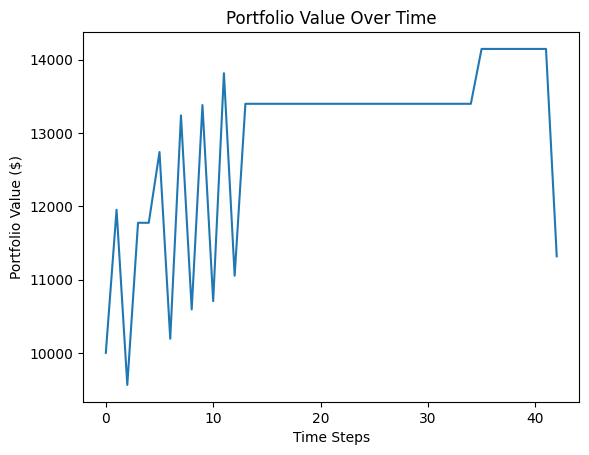

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
threshold = 0.02
initial_balance = 10000
stop_loss_pct = 0.03
take_profit_pct = 0.06
position = 0
balance = initial_balance
portfolio = []

# Validate data
y_actual = np.maximum(y_actual, 0.01)
y_pred = np.maximum(y_pred, 0.01)

# Smooth predictions to reduce noise
y_pred_smoothed = np.convolve(y_pred, np.ones(3) / 3, mode='same')

for i in range(len(y_pred_smoothed) - 1):
    predicted_change = (y_pred_smoothed[i + 1] - y_pred_smoothed[i]) / y_pred_smoothed[i]
    current_price = y_actual[i]

    # Dynamic threshold based on historical volatility
    volatility = np.std(y_actual[:i + 1]) if i > 10 else 0.02
    dynamic_threshold = max(threshold, volatility)

    # Trading logic
    if position == 0:  # No position
        trade_balance = 0.1 * balance  # Allocate 10% of balance for trading
        if predicted_change > dynamic_threshold:  # Buy signal
            position = trade_balance / current_price
            balance -= trade_balance
            stop_loss_price = current_price * (1 - stop_loss_pct)
            take_profit_price = current_price * (1 + take_profit_pct)
            print(f"Buying at {current_price:.2f}, Position: {position:.2f} shares, Stop-Loss: {stop_loss_price:.2f}, Take-Profit: {take_profit_price:.2f}")
        elif predicted_change < -dynamic_threshold:  # Short signal
            position = -trade_balance / current_price
            balance -= trade_balance
            stop_loss_price = current_price * (1 + stop_loss_pct)
            take_profit_price = current_price * (1 - take_profit_pct)
            print(f"Short-selling at {current_price:.2f}, Position: {position:.2f} shares, Stop-Loss: {stop_loss_price:.2f}, Take-Profit: {take_profit_price:.2f}")

    elif position > 0:  # Long position
        if current_price <= stop_loss_price:  # Stop-loss hit
            balance += position * current_price
            position = 0
            print(f"Selling at {current_price:.2f} (Stop-Loss), Balance: {balance:.2f}")
        elif current_price >= take_profit_price:  # Take-profit hit
            balance += position * current_price
            position = 0
            print(f"Selling at {current_price:.2f} (Take-Profit), Balance: {balance:.2f}")

    elif position < 0:  # Short position
        if current_price >= stop_loss_price:  # Stop-loss hit for short
            balance -= position * current_price
            position = 0
            print(f"Covering short at {current_price:.2f} (Stop-Loss), Balance: {balance:.2f}")
        elif current_price <= take_profit_price:  # Take-profit hit for short
            balance -= position * current_price
            position = 0
            print(f"Covering short at {current_price:.2f} (Take-Profit), Balance: {balance:.2f}")

    # Update portfolio value
    portfolio.append(balance + (position * current_price if position != 0 else 0))

# Final balance
final_balance = balance + (position * y_actual[-1] if position != 0 else 0)
print(f"Final Portfolio Value: {final_balance:.2f}")

# Plot portfolio value
plt.plot(portfolio)
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value ($)")
plt.show()

In [ ]:
Profits = final_balance - initial_balance
print(f"Profits: {Profits:.2f}")

Profits: 2108.47


Conclusions¶
The notebook demonstrates a comprehensive pipeline for financial forecasting using deep learning and public sentiment. While promising, the strategy requires further refinement with additional datasets and hyperparameter tuning to maximize real-world applicability.

Key Insights:
Incorporating sentiment analysis enhances predictive accuracy for stock price movements, particularly during volatile periods.
The LSTM model effectively captures long-term dependencies, critical for financial time series.

A robust trading strategy with defined stop-loss and take-profit mechanisms can further leverage the model's predictions.